In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from auxiliary import get_base_network_name

net_dir = '../networks/ER'

In [196]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

attack = 'Ran'
meank = 5
N_values = [250, 500, 1000, 2000, 4000, 8000, 16000]
compare_fast = False
if compare_fast:
    dfs = {}
    for N in N_values:
        df = load_dataframe(attack, N, meank)
        dfs[N] = df

    fast_dfs = {}
    for N in N_values:
        df = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        fast_dfs[N] = df
        
else:
    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    for N in N_values:
        dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)

KeyError: 4000

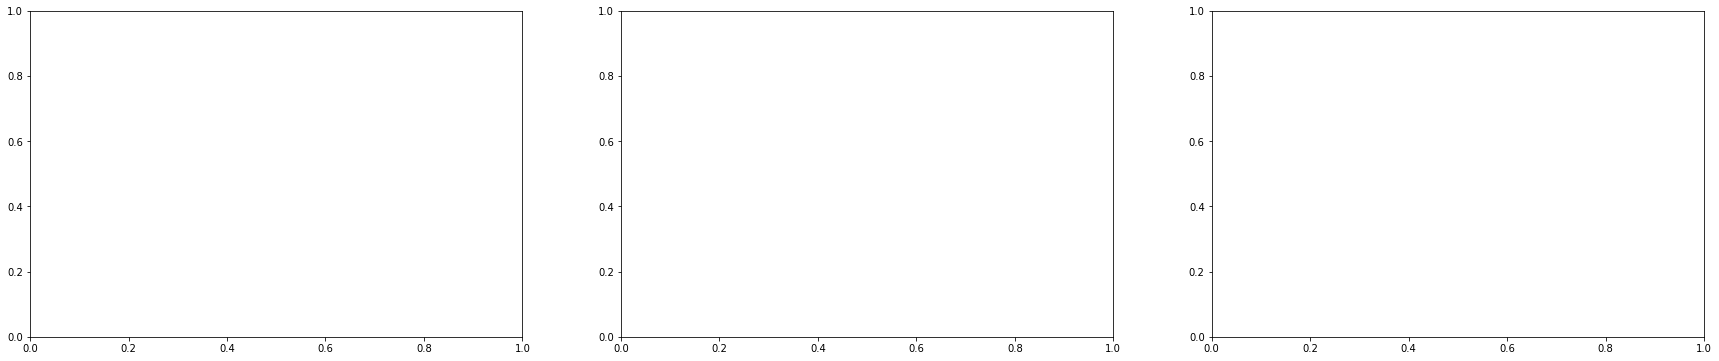

In [81]:
ncols = 3
fig, axes = plt.subplots(figsize=(10*ncols, 6), ncols=ncols)

ax = axes[0]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.Nsec)
ax.set_xlim(0.65, 0.85)
ax.set_ylim(5, 11)

ax = axes[1]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.meanS)
ax.set_xlim(0.65, 0.85)
ax.set_ylim(2, 4)

ax = axes[2]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.varSgcc)
ax.set_xlim(0.65, 0.85)
#ax.set_ylim(2, 4)

plt.show()

In [140]:
S1_over_S2_values = {}
for N in N_values:
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S1_over_S2_values[N] = S1_over_S2

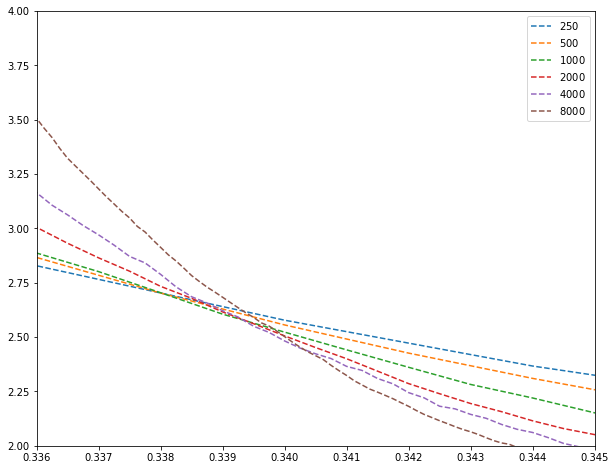

In [152]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_xlim(0.79, 0.81)
#ax.set_xlim(0.5, 0.6)
#ax.set_xlim(0.46, 0.48)
if attack == 'DegU':
    ax.set_xlim(0.336, 0.345)
    ax.set_ylim(2, 4)
#ax.set_ylim(2.1, 2.6)
#ax.set_ylim(2.1, 3)
#ax.set_ylim(1, 2.5)
for i, N in enumerate(N_values):

    #df = dfs1000[N]
    #S1_over_S2 = N * df.Sgcc / df.Nsec
    #ax.plot(df.f, S1_over_S2, ':', color=colors[i])
    
    df = dfs10000[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    ax.plot(df.f, S1_over_S2, '--', label=r'${{{}}}$'.format(N), color=colors[i])
    
    #df = dfs20000[N]
    #S1_over_S2 = N * df.Sgcc / df.Nsec
    #ax.plot(df.f, S1_over_S2, '-', color=colors[i])
    
#ax.axvline(0.8, linestyle='--', color='k')
ax.legend(loc='best')
plt.show()

In [153]:
def compute_fc_v2(dfs, min_f, max_f):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for Na in N_values:
        for Nb in N_values:
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

fmin = 0.4
fmax = 0.5
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs1000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs10000, fmin, fmax)))
#print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs20000, fmin, fmax)))

0.4893 0.0011
0.4887 0.0029


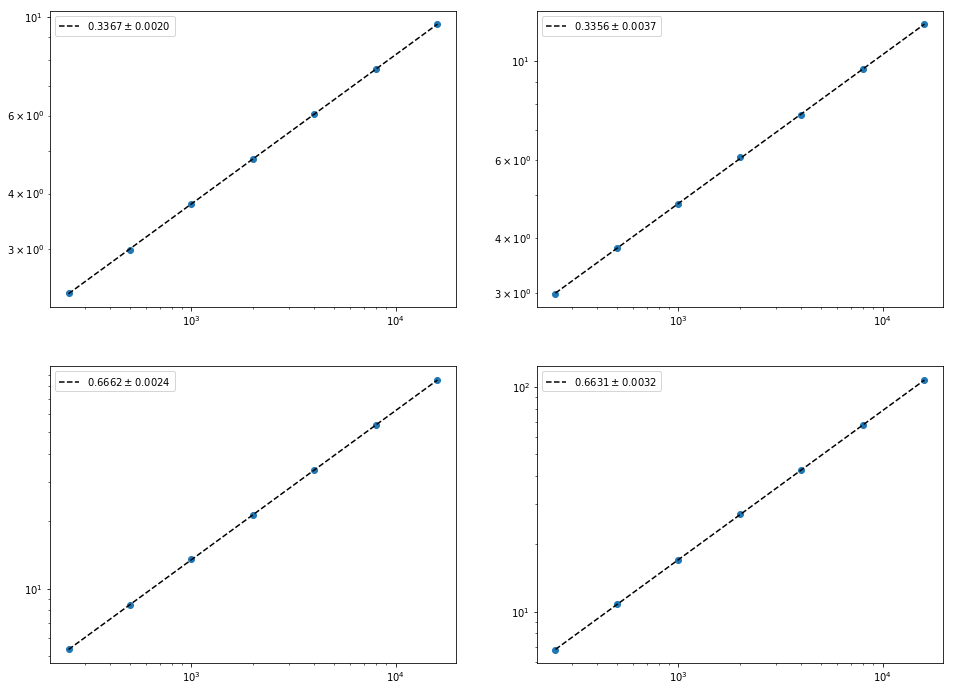

In [206]:
from sklearn.linear_model import LinearRegression

def getPeaks(dfs, measure):
    N_values = sorted(dfs.keys())
    
    fc_values  = []
    max_values = []
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        max_idx = df[measure].idxmax()
        max_value = df[measure][max_idx]
        
        fc_values.append(max_idx/N)
        max_values.append(max_value)
        
    return fc_values, max_values

def get_critical_measures(dfs, measure, fc):
    
    N_values = sorted(dfs.keys())
    
    if fc == 'peak':
        fc_values, _ = getPeaks(dfs, measure)
    elif isinstance(fc, float): 
        fc_values = [fc] * len(N_values)
    else:
        print('ERROR')
        
    crit_values = []    
    for i, N in enumerate(N_values):
        df = dfs[N]
        fc = fc_values[i]
            
        if measure == 'Sgcc':
            crit_values.append(N*df[measure][int(fc*N)])
        else:
            crit_values.append(df[measure][int(fc*N)])
        
    return np.array(crit_values)  

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):
    linear_regressor = LinearRegression() 
    #X = np.log(sizes).reshape(-1, 1)
    #Y = np.log(values).reshape(-1, 1)
    #linear_regressor.fit(X, Y)  # perform linear regression
    #Y_pred = linear_regressor.predict(X)  # make predictions
    #slope = linear_regressor.coef_[0][0]
    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

dfs = dfs20000
#del dfs[250]
#del dfs[500]
N_values = list(dfs.keys())


ncols = 2
nrows = 2
fig, axes_cols = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=2)

for i, measure in enumerate(['meanS', 'Nsec']):

    axes = axes_cols[i]
    
    measure_values = get_critical_measures(dfs, measure, 0.8)
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend(loc='best')

    measure_values = get_critical_measures(dfs, measure, fc='peak')
    Y_pred, slope, y_err = getLinearReg(N_values, measure_values)
    ax = axes[1]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(N_values, measure_values, 'o')
    ax.plot(N_values, Y_pred, '--', color='k', label=r'${{{:.4f}}}\pm{{{:.4f}}}$'.format(slope, y_err))
    ax.legend(loc='best')

plt.show()

In [194]:
X = np.log(N_values)
Y = np.log(measure_values)
coeffs, cov = np.polyfit(X, Y, 1, cov=True)
errors = np.sqrt(np.diag(cov))
print(coeffs)
print(cov)
print(errors)

[ 0.33468433 -0.74538288]
[[ 5.77713415e-06 -4.79158374e-05]
 [-4.79158374e-05  4.02967617e-04]]
[0.00240357 0.02007405]
